<a href="https://colab.research.google.com/github/stratis-forge/segmentation-workflows/blob/main/demo_preprocessing_for_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing data for training and deploying AI models

## Introduction
In this notebook we demonstrate sample preprocessing operations availble in CERR for training/deploying AI models. 

[CERR's Wiki](https://github.com/cerr/CERR/wiki/Building-Deep-Learning-Segmentation-Models) provides additional details of the preprocessing pipeline, supported methods, and configuring desired transformations.

### Requirements

* GNU Octave with `io`,`image` & `statistics` packages
* [CERR](https://github.com/cerr/CERR/tree/octave_dev)
* JSON configuration file
* Python packages for visualization

Note: Installing these tools may incur a one-time extra runtime overhead.

### I/O

In this example, we use sample images in CERR's native `planC` format (imported from DICOM) to demonstrate selected methods for cropping , transforming image orientation, and generating 2.5D images.
 
### Results
This notebook comes with a static visualization of a sample preprocessing operations.

---

## Install dependencies
Uncomment (`Ctrl+/`) the following sections to install (1) Octave with required packages (2) Oct2py and (3) CERR.

### Download latest Octave compile

In [1]:
%%capture
# ! apt-get update
# ! apt-get install libgraphicsmagick++1-dev libsuitesparse-dev libqrupdate1 \
# libfftw3-3 gnuplot zsh openjdk-8-jdk

In [2]:
# Download latest compiled octave package 
# def get_octave(root_path):
#   os.chdir(root_path)
#   with urllib.request.urlopen("https://api.github.com/repos/cerr/octave-colab/releases/latest") as url:
#       data = json.loads(url.read().decode())
#   fname = data['assets'][0]['name']
#   requrl = data['assets'][0]['browser_download_url']
#   urllib.request.urlretrieve(requrl, fname)
#   # Unzip, identify octave folder name
#   !tar xf {fname}
#   top_folder = !tar tf {fname} | head -1
#   octave_folder = top_folder[0][:-1]
#   octave_path = os.path.join(root_path,octave_folder)
#   return octave_path

In [3]:
# Set path to Octave exectuable
# import os, urllib.request, json
# octave_path = get_octave('/content')
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'  #Replace with OCTAVE_EXECUTABLE path
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']    #Replace with Octave path

### Install Octave-Python bridge

In [4]:
# %%capture
# ! pip3 install octave_kernel
# ! pip3 install oct2py==5.3.0

### Download CERR

In [5]:
%%capture
# import os
# !git clone --single-branch --branch octave_dev https://www.github.com/cerr/CERR.git
# currDir = os.getcwd()
# os.chdir("/content/CERR")
# !git checkout c2b65179da40622bc7b095f679edd17f5ebc681e
# os.chdir(currDir)

## Sample preprocessing with CERR

### Load Octave-Python bridge

In [6]:
%load_ext oct2py.ipython
from oct2py import octave

### Install Octave packages

In [7]:
%%capture
%%octave
pkg load image
pkg load statistics
pkg load io

### Add CERR to Octave Path

In [8]:
%%octave
currDir = pwd();
CERR_path = '/content/CERR';
cd(CERR_path)
addToPath2(CERR_path)
cd(currDir)

### Preprocessing
* This demo uses [sample](https://github.com/stratis-forge/segmentation-workflows/tree/main/sample_settings) configuration files distributed with STRATIS.  

  `!git clone https://github.com/stratis-forge/segmentation-workflows.git`

* See [documentation](https://github.com/cerr/CERR/wiki/JSON-configuration-for-deep-learning-based-segmentation) to define custom configurations.

In [9]:
%%capture
%%octave

function [scanOutC,maskOutC] = getPreprocData(configFile,planC)
  skipMaskExport = 0;
  scanNum = 1;
  optS = readDLConfigFile(configFile)
  [scanOutC, maskOutC] = extractAndPreprocessDataForDL(optS,...
    planC,skipMaskExport,scanNum);
  scanOutC = scanOutC{1}; 
  maskOutC = maskOutC{1};
end

In [10]:
%%capture
%%octave

scanC = cell(4,1);
maskC = cell(4,1);

# Eg.1 Crop to patient outline
sampleHNData = ['/content/CERR/Unit_Testing/data_for_cerr_tests/CERR_plans/',...
'head_neck_ex1_20may03_resamp.mat.bz2'];
configFile = '/content/sample_settings/sample_config1.json';

tmp = tempdir();
plan1C = loadPlanC(sampleHNData,tmp);
plan1C = updatePlanFields(plan1C);
[scanOutC,maskOutC] = getPreprocData(configFile,plan1C);
scanC{1} = scanOutC{1}{1};
maskC{1} = maskOutC{1}{1};

# Eg.2 Chaining cropping operations
sampleLungData = ['/content/CERR/Unit_Testing/data_for_cerr_tests/CERR_plans/',...
                  'lung_ex1_20may03.mat.bz2'];
configFile = '/content/sample_settings/sample_config2.json';
plan2C = loadPlanC(sampleLungData,tmp);
plan2C = updatePlanFields(plan2C);
[scanOutC,maskOutC] = getPreprocData(configFile,plan2C);
scanC{2} = scanOutC{1}{1};
maskC{2} = maskOutC{1}{1};

# Eg3. Transforming image orientation 
configFile = '/content/sample_settings/sample_config3.json';
[scanOutC,maskOutC] = getPreprocData(configFile,plan1C);
scanC{3} = scanOutC;
maskC{3} = maskOutC;

# Eg4. Chaining pre-processing operations
configFile = '/content/sample_settings/sample_config4.json';
[scanOutC,maskOutC] = getPreprocData(configFile,plan1C);
scanC{4} = scanOutC{1};
maskC{4} = maskOutC{1};

### Visualization

In [11]:
%octave_pull scanC maskC

In [12]:
import matplotlib.pyplot as plt
import numpy as np

cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens]

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def get_extent(img):
    dx = 1
    dy = 1
    img_size = np.shape(img)
    x = np.arange(0, img_size[0], dx)
    y = np.arange(0, img_size[1], dy)
    extent = np.min(x), np.max(x), np.min(y), np.max(y)


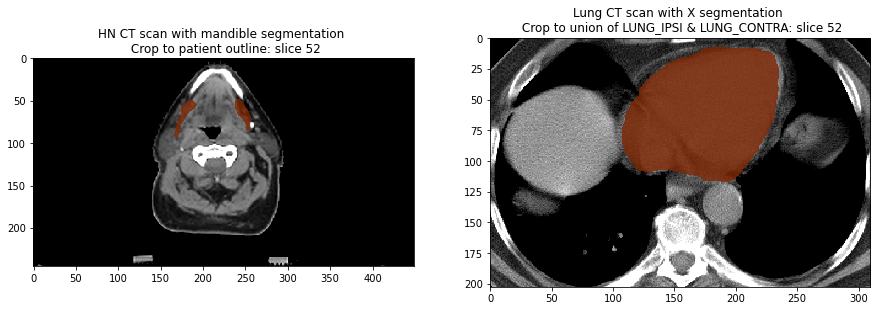

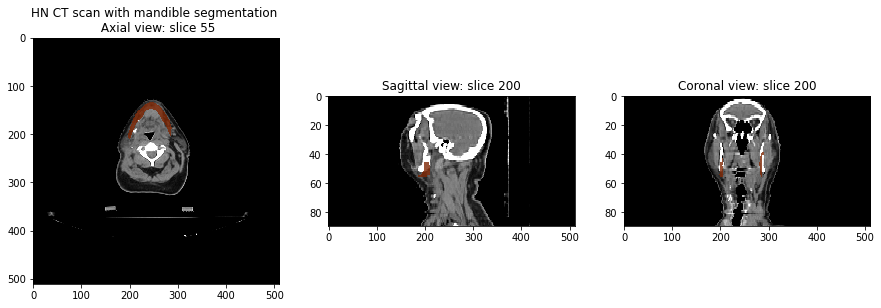

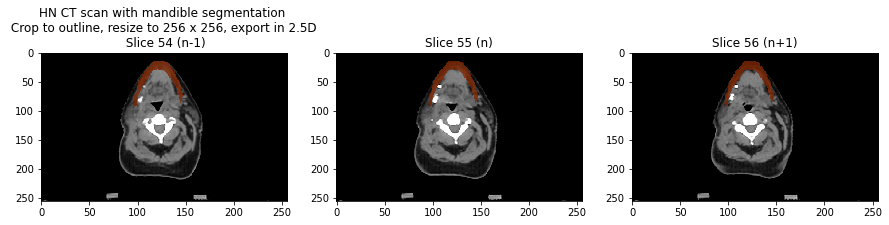

In [13]:
# Display processed data

def plotSelectedSlice(scanArray, maskArray, slice, title, ax, ar=1, addSlcFlag=1,):
    scanSize = np.shape(scanArray)

    window_center = 40
    window_width = 400
    extent = get_extent(scanArray)

    windowed_img = window_image(scanArray[:,:,slice],
                                window_center,window_width)
    ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
    interpolation='none', extent=extent)
    if addSlcFlag:
        title = title + ': slice ' + str(slice)
    ax.title.set_text(title)
    fontdict = {'fontsize' : 100}

    mask_cmap = cmaps[0]
    mask_cmap.set_under('k', alpha=0)
    im2 = ax.imshow(maskArray[:,:,slice-1], 
    cmap=mask_cmap, alpha=.8, extent=extent,
    clim=[0.5, 1],
    interpolation='none', ) 
    
    ax.set_aspect(ar)
    

#---- Display results of various preprocessing configurations ---

# Display results of config 1
scanArray = scanC[0]
maskArray = maskC[0]
slice = 52
plotTitle = 'HN CT scan with mandible segmentation \n Crop to patient outline'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax1)       

# Display results of config 2
scanArray = scanC[1]
maskArray = maskC[1]
plotTitle = 'Lung CT scan with X segmentation \n Crop to union of LUNG_IPSI & LUNG_CONTRA'
plotSelectedSlice(scanArray, maskArray, slice, plotTitle,ax2)       

# Display results of config 3
scanViewC = scanC[2] 
maskViewC = maskC[2]
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))

slice = 55
plotTitle = 'HN CT scan with mandible segmentation \n Axial view'
scanArray = scanViewC[0][0]
maskArray = maskViewC[0]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax1)   
slice = 200
plotTitle = 'Sagittal view'
scanArray = scanViewC[1][0]
maskArray = maskViewC[1]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax2, ar=3)  
plotTitle = 'Coronal view'
scanArray = scanViewC[2][0]
maskArray = maskViewC[2]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax3, ar=3)       

#Display results of config4
scan25dC = scanC[3]
maskArray = maskC[3][0]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,15))
slice = 55

scanArray = scan25dC[0]
plotTitle = 'HN CT scan with mandible segmentation \n Crop to outline, resize to 256 x 256, export in 2.5D \n Slice 54 (n-1)'
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax1, ar=0.6, addSlcFlag=0)   

plotTitle = 'Slice 55 (n)'
scanArray = scan25dC[1]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax2, ar=0.6, addSlcFlag=0)   

plotTitle = 'Slice 56 (n+1)'
scanArray = scanArray = scan25dC[2]
plotSelectedSlice(scanArray, maskArray, slice, plotTitle, ax3, ar=0.6, addSlcFlag=0)   
